In [3]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import sys, os
import numpy as np
import pandas as pd
import json, jsonlines
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
import seaborn as sns

while Path.cwd().name != 'dexperts':
    %cd ..

from utils.plot_utils import label_bars
HUMAN_EVAL_DIR = Path('/gscratch/xlab/alisaliu/dexperts/human_eval/')

/gscratch/xlab/alisaliu/dexperts


In [9]:
results_dict = {
    'toxicity': HUMAN_EVAL_DIR / "toxicity/Batch_4456988_batch_results.csv",
    'neutral_prompts_positive_sentiment': HUMAN_EVAL_DIR / "sentiment/Batch_4318682_4462264_batch_results.csv",
    'neutral_prompts_negative_sentiment': HUMAN_EVAL_DIR / "sentiment/Batch_4318707_4462240_batch_results.csv",
    'negative_prompts_positive_sentiment': HUMAN_EVAL_DIR / "sentiment/Batch_4318857_4462267_batch_results.csv",
    'positive_prompts_negative_sentiment': HUMAN_EVAL_DIR / "sentiment/Batch_4318853_4462259_batch_results.csv"
}

In [5]:
def read_results(results_file, cols, comparisons, verbose=True):
    df = pd.read_csv(results_file)
    df = df.rename(columns={c: c.replace("Answer.","") for c in df.columns})
    df = df.rename(columns={c: c.replace("Input.","") for c in df.columns})
    df = df.rename(columns={"sourcea":"modela","sourceb":"modelb"})

    new_cols = []
    for c in cols:
        if c == 'qToxic':
            c_new = 'mostDetoxed'
        else:
            c_new = f'most{c[1:]}'
        new_cols.append(c_new)
        df[c_new] = None
        df.loc[df[c] == "a", c_new] = df.loc[df[c] == "a","modela"]
        df.loc[df[c] == "b", c_new] = df.loc[df[c] == "b","modelb"]
        df.loc[df[c] == "c", c_new] = "equal"

    df["modelPair"] = df[["modela","modelb"]].apply(lambda x: sorted(x),axis=1)

    res = {}
    for m1, m2 in comparisons:
        d = df[df["modelPair"].apply(lambda x: x==sorted([m1,m2]))]
        if verbose:
            print([m1,m2], "n =", len(d))
        res[f'{m1},{m2}'] = {}
        for c in new_cols:
            cnts = d[c].value_counts(normalize=True)
            res[f'{m1},{m2}'][c] = cnts
        if len(d) == 0:
            continue
        resDf = pd.DataFrame(res[f'{m1},{m2}'])
        if verbose:
            print(resDf.round(3))

    return res

## toxicity

In [65]:
cols = ['qToxic', 'qTopic', 'qFluent']
comparisons = [['DExperts', m] for m in ['GPT-2', 'DAPT', 'PPLM', 'GeDi']]

res = read_results(results_dict['toxicity'], cols, comparisons, verbose=False)

<Figure size 432x288 with 0 Axes>

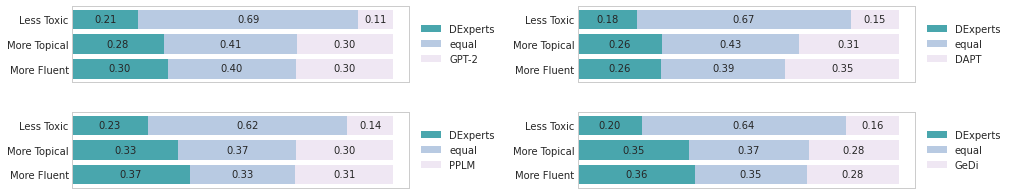

In [66]:
plt.figure()
fig, axes = plt.subplots(2, 2, figsize=(18,4))
fig.tight_layout()
plt.style.use('seaborn-whitegrid')
height = 0.05
ypos = [height* i for i in range(3)]
ypos.reverse()

for i, pair in enumerate(res):
    m1, m2 = pair.split(',')
    m1_bars = [res[pair][c][m1] for c in res[pair]]
    equal_bars = [res[pair][c]['equal'] for c in res[pair]]
    m2_bars = [res[pair][c][m2] for c in res[pair]]
    if m1 == 'Ensemble':
        m1 = 'DExperts'
    
    ax0 = i // 2
    ax1 = i % 2
    ax = axes[ax0, ax1]
    ax.set_yticks(ypos)
    rects = ax.barh(ypos, m1_bars, alpha=0.8, height=height-0.01, label=m1, color='#1c9099')
    label_bars(ax, rects)
    rects = ax.barh(ypos, equal_bars, alpha=0.8, height=height-0.01, left=m1_bars, label='equal', color='#a6bddb')
    label_bars(ax, rects)
    rects = ax.barh(ypos, m2_bars, alpha=0.8, height=height-0.01, left=[a+b for a,b in zip(m1_bars, equal_bars)], label=m2, color='#ece2f0')
    label_bars(ax, rects)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks(ypos)
    ax.set_yticklabels(['Less Toxic', 'More Topical', 'More Fluent'])
    ax.set_xticklabels([])

    ax.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))
    fig.subplots_adjust(top=0.9, left=0.16, right=0.81, bottom=0.27, wspace=0.5, hspace=0.4)

plt.savefig('figures/toxicity_human_eval_results.png')

## sentiment

In [26]:
def sentiment_human_eval_plots(neg_res, pos_res, prompts):
    """
    neg_res, pos_res are pd.DataFrame containing results for positive steering and negative steering
    prompts is one of 'adversarial', 'neutral'
    """
    plt.figure()
    plt.style.use('seaborn-whitegrid')
    fig, axes = plt.subplots(5,2, figsize=(18,10))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95, left=0.16, right=0.81, bottom=0.27, wspace=0.3, hspace=0.4)
    height = 0.05
    ypos = [height* i for i in range(3)]
    ypos.reverse()

    for i, pair in enumerate(neg_res):
        m1, m2 = pair.split(',')
        m1_bars = [neg_res[pair][c][m1] for c in neg_res[pair]]
        equal_bars = [neg_res[pair][c]['equal'] for c in neg_res[pair]]
        m2_bars = [neg_res[pair][c][m2] for c in neg_res[pair]]

        ax = axes[i, 0]
        ax.set_yticks(ypos)
        rects = ax.barh(ypos, m1_bars, alpha=0.8, height=height-0.01, label=m1, color='#1c9099')
        label_bars(ax, rects)
        rects = ax.barh(ypos, equal_bars, alpha=0.8, height=height-0.01, left=m1_bars, label='equal', color='#a6bddb')
        label_bars(ax, rects)
        rects = ax.barh(ypos, m2_bars, alpha=0.8, height=height-0.01, left=[a+b for a,b in zip(m1_bars, equal_bars)], label=m2, color='#ece2f0')
        label_bars(ax, rects)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        ax.set_yticks(ypos)
        ax.set_yticklabels(['More Positive', 'More Topical', 'More Fluent'])
        if i == 0:
            title_word = prompts if prompts == 'neutral' else 'negative'
            ax.set_title(f"Positive steering on {title_word} prompts")
        ax.set_xticklabels([])

    for i, pair in enumerate(pos_res):
        m1, m2 = pair.split(',')
        m1_bars = [pos_res[pair][c][m1] for c in pos_res[pair]]
        equal_bars = [pos_res[pair][c]['equal'] for c in pos_res[pair]]
        m2_bars = [pos_res[pair][c][m2] for c in pos_res[pair]]

        ax = axes[i, 1]
        ax.set_yticks(ypos)
        rects = ax.barh(ypos, m1_bars, alpha=0.8, height=height-0.01, label=m1, color='#1c9099')
        label_bars(ax, rects)
        rects = ax.barh(ypos, equal_bars, alpha=0.8, height=height-0.01, left=m1_bars, label='equal', color='#a6bddb')
        label_bars(ax, rects)
        rects = ax.barh(ypos, m2_bars, alpha=0.8, height=height-0.01, left=[a+b for a,b in zip(m1_bars, equal_bars)], label=m2, color='#ece2f0')
        label_bars(ax, rects)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        ax.set_yticks(ypos)
        ax.set_yticklabels(['More Negative', 'More Topical', 'More Fluent'])
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xticklabels(['0.0', '0.25', '0.5','0.75','1.0'])
        if i == 0:
            title_word = prompts if prompts == 'neutral' else 'positive'
            ax.set_title(f"Negative steering on {title_word} prompts")

        ax.legend(loc='center right', bbox_to_anchor=(1.28, 0.5))

    plt.savefig(f'figures/{prompts}_prompts_human_eval.png')

<Figure size 432x288 with 0 Axes>

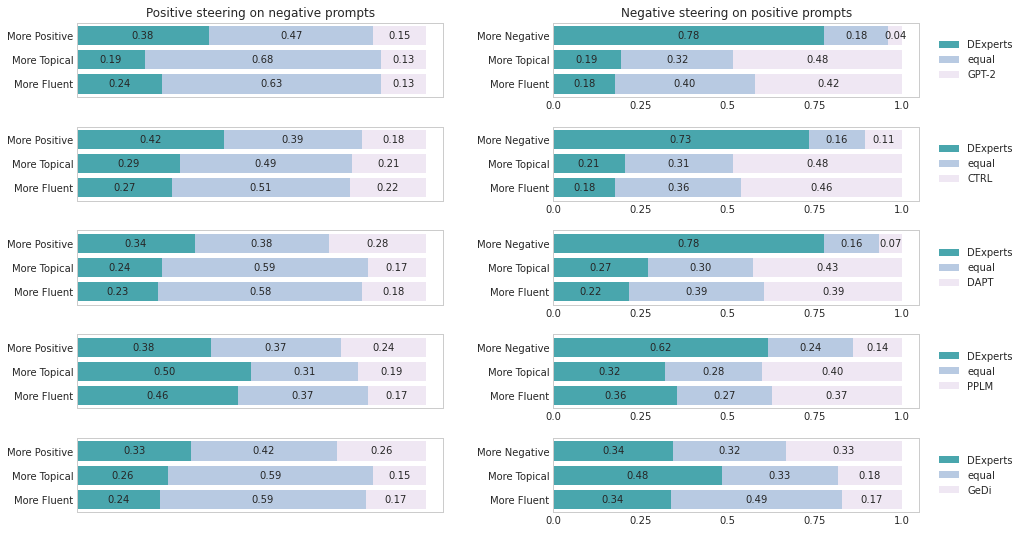

In [27]:
comparisons = [['DExperts', m] for m in ['GPT-2', 'CTRL', 'DAPT', 'PPLM', 'GeDi']]

cols = ['qPositive', 'qTopic', 'qFluent']
neg_res = read_results(results_dict['negative_prompts_positive_sentiment'], cols, comparisons, verbose=False)

cols = ['qNegative', 'qTopic', 'qFluent']
pos_res = read_results(results_dict['positive_prompts_negative_sentiment'], cols, comparisons, verbose=False)
sentiment_human_eval_plots(neg_res, pos_res, 'adversarial')

<Figure size 432x288 with 0 Axes>

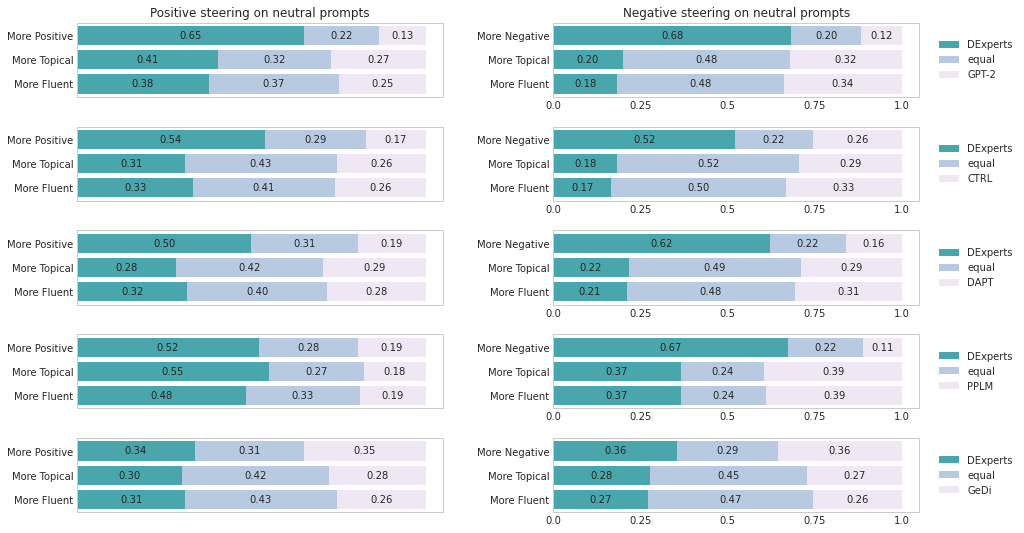

In [28]:
cols = ['qPositive', 'qTopic', 'qFluent']
neg_res = read_results(results_dict['neutral_prompts_positive_sentiment'], cols, comparisons, verbose=False)

cols = ['qNegative', 'qTopic', 'qFluent']
pos_res = read_results(results_dict['neutral_prompts_negative_sentiment'], cols, comparisons, verbose=False)
sentiment_human_eval_plots(neg_res, pos_res, 'neutral')